# Ising Model with Neural Network

Author: Shu-Hao Yeh (shuhaoyeh.ds@gmail.com)

In [1]:
# Environment setup
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from functools import partial

rc('text', usetex=True)

# to make this notebook's output stable across runs
def reset_graph(seed=3):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Ising Model

The Ising model, named after the German physicist Ernst Ising, is a mathematical model of ferromagnetism and also an important model system for understanding phase transitions. Consider a system of $N^2$ spins arranged on a $N$ by $N$ square lattice as illustrated in Fig.$~$1:


<figure>
<img src = "./img/Ising_SqLatt.png", width=200, height=600>

<center><figcaption> Figure 1: Spins on a square lattice. </figcaption></center>
</figure>

Each spin $s_i$ can be in one of the two states, -1 (spin points down) or +1 (spin points up). Ising model suggests that the interaction energy is:

$-J\sum_{ij}s_i s_j \;,$
where $J$ is the coupling constant and only the interactions between the nearest neighbor spins are included. The total energy of the system is represented by its Hamiltonian:

$$\mathcal{H} = -J\sum_{ij}s_i s_j - H\sum_i s_i \;,$$
where $H$ is the external magnetic field. In all the simulations we assumed that there is no external magnetic field applied to the system $(H = 0)$ and the coupling constant is positive $(J > 0)$.


## Monte Carlo Simulation

The following code simulates the 2D Ising model using the Metropolis algorithm:

1. Initialize the spin configuration.
2. Randomly select one spin in the lattice and flip the sign. $\Delta E = E_{\mathrm{new}} - E_{\mathrm{old}}$.
3. If the total energy of the new spin configuration is lower ($\Delta E < 0$), accept the move. Otherwise draw a random number $x$ between 0 and 1, and accept the change only if $\exp(-\Delta E / k_B T) \ge x$.
4. Repeat Step 2 and 3.

### Parameters for Monte Carlo Simulation

In [2]:
N = 20 # Lattice points on each edge
T = 8 # Temperature (in the unit of J/k_B), the critical temperature in this case is 2/log(1+sqrt(2)) ~= 2.269
ns = 5000 # Number of Monte Carlo steps

### Initialization

The initial spin configuration is set to all spins pointing up ($s_i = 1$).

(0.5, 20.5, 20.5, 0.5)

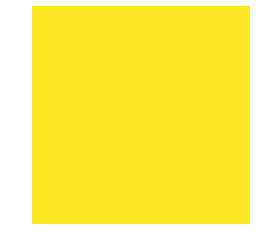

In [3]:
# Initial state
reset_graph()
M = np.ones((N,N), dtype=int)

fig, ax = plt.subplots()
ax.imshow(M, extent=[0.5, N + 0.5, N + 0.5 , 0.5], vmin=-1, vmax=1)
plt.axis('off')

### Setup the energy evaluation function

The code below defines the function that calculates the total energy of the system depending on the spin configuration.

In [4]:
def estE(M): # Energy evaluation function
    total = 0
    for i in range(N-1): 
        total -= np.sum(np.multiply(M[i,:] , M[i+1,:])) # Sum over element-wise multiplication between neighbor rows
        
    for i in range(N-1):
        total -= np.sum(np.multiply(M[:,i] , M[:,i+1])) # Sum over element-wise multiplication between neighbor columns
    
    return total

### Monte Carlo Iterations

In [5]:
# Start the Monte Carlo iterations
for i in range(ns):
    rele = np.random.randint(N**2)
    m,n = divmod(rele,N)
    newM = np.copy(M)
    newM[m,n] *= -1
    dE = estE(newM) - estE(M)
    if dE <= 0:
        np.copyto(M,newM)
    elif np.random.random_sample() <= np.exp(-dE/T):
        np.copyto(M,newM)
    
print("Complete {:d} steps".format(ns))

Complete 5000 steps


## Visualize the results

The final spin configuration is shown below with its corresponding magnetization: $$\langle M \rangle = \frac{1}{N^2} \sum_i^{N^2} s_i$$ provided. The yellow and blue color in the figure below represent spin up and down respectively.

<M> =  0.095


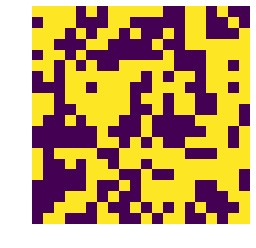

In [6]:
fig, ax = plt.subplots()
ax.imshow(M, extent=[0.5, N + 0.5, N + 0.5 , 0.5], vmin=-1, vmax=1)
plt.axis('off')

print("<M> = ", np.sum(M)/(N**2))

## Discriminating between the low- and high-temperature phase by neural network

Recently machine learning has been exploited in studying phases and phase transitions in condensed-matter research. The code below demonstrates a trained neural network which is capable of descriminating between the low-temperature ferromagnetic phase and the high-temperature paramagnetic phase in the ferromagnetic Ising model. The trained neural network (trained on square lattice) can be further exploited to estimate the critical temperature of Ising model with a different lattice architecture (ex. triangular lattice, Fig.$~$2).

<figure>
<img src = "./img/Ising_TriLatt.png", width=200, height=600>

<center><figcaption> Figure 2: Spins on a triangular lattice. </figcaption></center>
</figure>



### Parameters for the neural network

The neural network is composed of an input layer of $N^2$ neurons with values assigned according to the spin configurations, a hidden layer of $N^2$ neurons, and an output layer of two neurons that categorize the phases. In the output layer, we labeled the low- and high-temperature phase as 0 and 1, respectively.

In [7]:
n_inputs = 20*20
n_hidden1 = 400
n_outputs = 2

In [8]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

### Cost function and optimizer

To prevent overfitting, we use a cross-entropy cost function with an $L2$ regularization term. The neural network is trained with using the Adam optimization.

In [9]:
scale = 0.025 # l2 regularization hyperparameter

my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.sigmoid,
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    logits = my_dense_layer(hidden1, n_outputs, activation=None, name="outputs")

In [10]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [11]:
learning_rate = 0.0001

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [12]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [13]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [14]:
n_epochs = 100
batch_size = 100

In [15]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

### Define the training, evaluation, and test set

The training set is composed of 200 samples per temperature value, where 20 linearly-spaced temperature values are used. To evenly include spin configurations in the low- or high-temperature phases, the temperature range is set from 1.3 to 3.2 $J/k_B$ (the critical temperature of square-lattice Ising model is $2/\ln\left(1+\sqrt{2}\right) \approx 2.269 J/k_B$). The spin configurations of square-lattice Ising model are generated by Monte Carlo simulations (using 5000 steps) introduced above, and the initial spin configurations across the samples are evenly set to either all spins pointing up or down. 

The validation set is generated in a similar fashion, the only difference is 50 samples are used per temperature value instead of 200. The test set consists of 250 samples per temperature value, using 20 linearly-spaced temperature values. The spin configurations of triangular-lattice Ising model are also generated by Monte Carlo simulations but a different temperature range is used (from 2.7 to 4.6 $J/k_B$, to include the critical temperature of triangular lattice Ising model, which is $4/\ln~3 \approx 3.641 J/k_B$).

In [16]:
Xdata = np.loadtxt("./Xtrain.txt", dtype=int)
# X_test = np.loadtxt("./Xtest.txt", dtype=int) # Square-lattice test set
X_test = np.loadtxt("./Xtest_tri.txt", dtype=int) # Triangular-lattice test set
valid_idx = np.kron(np.ones(20,dtype=int), np.arange(200,250,dtype=int)) + np.kron(250*np.arange(0,20,dtype=int),np.ones(50,dtype=int))
train_idx = np.kron(np.ones(20,dtype=int), np.arange(0,200,dtype=int)) + np.kron(250*np.arange(0,20,dtype=int),np.ones(200,dtype=int))
X_valid = Xdata[valid_idx]
X_train = Xdata[train_idx]
y_train = np.concatenate((np.zeros(2000, dtype=int), np.ones(2000, dtype=int)))
y_valid = np.concatenate((np.zeros(500, dtype=int), np.ones(500, dtype=int)))
y_test = np.concatenate((np.zeros(2500, dtype=int), np.ones(2500, dtype=int)))

In [17]:
cost_history = np.zeros(shape=[n_epochs+1],dtype=float)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs + 1):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})        
        cost_history[epoch] = acc_batch
        
        if epoch % 10 == 0:
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.59 Validation accuracy: 0.462
10 Batch accuracy: 0.91 Validation accuracy: 0.919
20 Batch accuracy: 0.94 Validation accuracy: 0.867
30 Batch accuracy: 0.94 Validation accuracy: 0.933
40 Batch accuracy: 0.99 Validation accuracy: 0.928
50 Batch accuracy: 0.94 Validation accuracy: 0.926
60 Batch accuracy: 0.93 Validation accuracy: 0.927
70 Batch accuracy: 0.94 Validation accuracy: 0.937
80 Batch accuracy: 0.94 Validation accuracy: 0.904
90 Batch accuracy: 0.93 Validation accuracy: 0.936
100 Batch accuracy: 0.93 Validation accuracy: 0.932


In [18]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [19]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:])

Predicted classes: [0 0 0 ... 1 1 1]
Actual classes:    [0 0 0 ... 1 1 1]


## Visualize the results

Text(0.5, 1.0, 'Model accuracy')

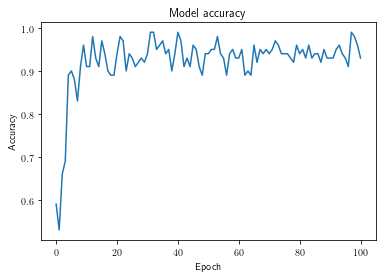

In [20]:
plt.plot(range(len(cost_history)),cost_history) # Print epoch vs accuracy
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model accuracy")

Text(0.5, 1.0, 'Square-lattice Ising Model')

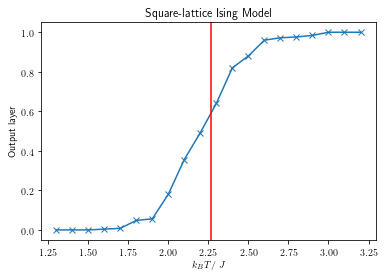

In [21]:
plt.plot(np.linspace(1.3, 3.2, num=20), np.mean(y_pred.reshape(-1, 250), axis=1), marker="x")
plt.xlabel(r"$k_B T /\;J$")
plt.ylabel('Output layer')
plt.axvline(x=2/np.log(1+np.sqrt(2)), color='r')
plt.title("Square-lattice Ising Model")

Text(0.5, 1.0, 'Triangular-lattice Ising Model')

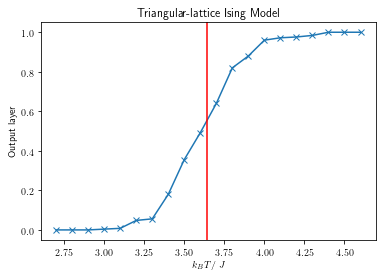

In [22]:
plt.plot(np.linspace(2.7, 4.6, num=20), np.mean(y_pred.reshape(-1, 250), axis=1), marker="x")
plt.xlabel(r"$k_B T /\;J$")
plt.ylabel('Output layer')
plt.axvline(x=4/np.log(3), color='r')
plt.title("Triangular-lattice Ising Model")

Ideally, the neural network should categorize the spin configurations generated below or above $T_c$ as in the low- or high-temperature phase, respectively. The red vertical line represents the critical temperature in the corresponding lattice structure. The average outputs of the neural network cross the value of 0.5 at temperature close to the critical temperature $T_c$. The neural network trained under square-lattice Ising model also successfuly predict the low- and high-temperature phases in the triangular-lattice Ising model.